In [1]:
import pycbc
import pandas as pd
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
from pycbc.frame import read_frame

import astropy
import astropy.units as u
from astropy.coordinates import Distance

import numpy as np

### Choice of python module for generating SNRs
Assuming I'm going to have mass, spins, redshift, then I can use either:
* pycbc
* gwcosmo

I've used gwcosmo before so I know what to do. BUT it would be useful to get to know how to use pycbc.

If using pycbc, then I need to identify the function that generates the SNRs from these parameters, or otherwise how to go about it.

What I could do is generate a waveform https://pycbc.org/pycbc/latest/html/waveform.html , make some assumptions on localisation and orientation, and basically recreate the gwcosmo method using pycbc.

There's some PyCBC tutorials here:

https://github.com/gwastro/PyCBC-Tutorials/tree/master/tutorial

and on the PyCBC site here is an example for getting SNRs:

https://pycbc.org/pycbc/latest/html/gw150914.html#calculate-the-signal-to-noise

also:

https://colab.research.google.com/github/gwastro/pycbc-tutorials/blob/master/tutorial/4_ChisqSignificance.ipynb



In [2]:
# import the samples
samples = pd.read_csv('params_for_SNR.csv', index_col=0)
samples

,mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2,chi_eff,tilt_1,tilt_2,sin_tilt_1,sin_tilt_2,chi_p,spin1z,spin2z,spin1x,spin2x
0,3.301867,0.992499,0.069194,0.245682,0.704116,0.570399,2.076198,3.277099,0.094257,0.789619,0.963805,0.710085,0.821368,0.200066,0.048720,0.140137,0.049133,0.201795
1,3.614000,0.990344,0.045051,0.032216,0.946914,-0.821554,1.373153,3.579102,0.008264,0.327299,2.534928,0.321486,0.570130,0.018165,0.042659,-0.026467,0.014483,0.018367
2,3.605017,0.993030,0.111428,0.477762,0.648840,0.619204,1.888312,3.579889,0.183675,0.864738,0.903068,0.760925,0.785230,0.372166,0.072299,0.295832,0.084788,0.375153
3,4.564583,0.950299,0.153021,0.114621,0.164766,-0.150329,2.278671,4.337718,0.004532,1.405276,1.721697,0.986333,0.988636,0.150930,0.025213,-0.017231,0.150930,0.113318
4,5.146561,0.962961,0.407271,0.179292,-0.216551,-0.463485,1.956511,4.955935,-0.085695,1.789077,2.052721,0.976271,0.886105,0.397607,-0.088195,-0.083099,0.397607,0.158872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.514865,0.874343,0.180901,0.104812,-0.556798,-0.260817,1.671250,5.696228,-0.066491,2.161322,1.834665,0.830648,0.965388,0.150265,-0.100726,-0.027337,0.150265,0.101184
995,3.607725,0.993575,0.287891,0.516216,0.754180,0.477210,1.246061,3.584545,0.231686,0.716391,1.073319,0.656667,0.878789,0.450316,0.217122,0.246343,0.189049,0.453645
996,3.914876,0.968723,0.232539,0.154071,0.936035,-0.484202,1.890546,3.792432,0.073853,0.359607,2.076247,0.351907,0.874956,0.129998,0.217665,-0.074602,0.081832,0.134805
997,3.083030,0.999738,0.085098,0.046986,0.396827,-0.526999,0.710591,3.082224,0.004508,1.162739,2.125862,0.917894,0.849866,0.078111,0.033769,-0.024762,0.078111,0.039932


For the psd strain info, see:

https://pycbc.org/pycbc/latest/html/pycbc_condition_strain.html?highlight=gwf


from CB for comparing rates https://gw-universe.org/population_model.html

### To be addressed
* All events at one location or uniformly distributed over the sky?
* Set time to cover an observing run?
* The below is for one detector, I will need to combine multiple detectors
* Check if my sampled masses are detector frame or not
* I need to assume an H0, 70?
    * also the distance conversion, co-moving, look-back, luminosity?
    * https://users.astro.ufl.edu/~guzman/ast6415/spring_16/projects/project01.html 
    * default cosmology is
* PyCBC appears to accept spin1z...and not chi_eff so need to perform a conversion
    * there must be the ability to feed the chi_eff and chi_p ???
    * which angle is tilt, to x,y,z?
    * I have an a_1 and a_2 and a theta_1 and theta_2
    * page 22 of https://arxiv.org/pdf/2010.14533.pdf , chi1 here is a_1 in other works https://arxiv.org/pdf/2001.06051.pdf
    * a1*cos_tilt1 = spin1z, that aligned with orbital angular momentum **check** 
        * confirmed
    * so then the rest of the spin should be in the orbital plane
        * does it matter between x and y? If not then I can just assign all of the rest of the spin to x OR y
        * I **need to** check the PyCBC code to see what it does with spinx and spiny and I can then determine if I can do the above

From the papers, for **spin**:

\begin{align}
\chi_{eff} &=  \frac{S_{1z} \times M_{1} + S_{2z} \times M_{2}}{M_{1} + M_{2}} \space \text{from PyCBC code} \\
&= \frac{M_{1} \vec{a_{1}} + M_{2} \vec{a_{2}}}{M_{1} + M{2}} \hat{L}_{N} \space \text{from paper} \\
&= \frac{M_{1} a_{1}\cos{t_{1}} + M_{2} a_{2}\cos{t_{2}}}{M_{1} + M{2}} \space \text{for t tilt angle between spin and L}\\
&= \frac{\chi_{1}\cos{\theta_{1} + q\chi_{2}\cos{\theta_2}}}{1+q} \space \text{from other paper chi is dimensionless spin}\\
&= \frac{M_{1} \chi_{1}\cos{\theta_{1}} + M_{2} \chi_{2}\cos{\theta_{2}}}{M_{1} + M{2}}\\
\end{align}

so $S_{1z} = a_{1} \times \cos{\theta_{1}}$

so then surely $a_{1} \times \sin{\theta{1}}$ is the dimensionless spin in the x, y plane. As the objects orbit this will oscillate between x and y, so I can say that all of it is initially in x or y.

For $\chi_{p}$ https://journals.aps.org/prd/pdf/10.1103/PhysRevD.91.024043

$\chi_{p} = \text{max}(a_{1}\sin{\theta_{1}}, \frac{4q + 3}{4+3q}qa_{2}\sin{\theta_2})$

what is the factor in front of the second term telling me?


In [4]:
# convert our redshifts into luminosity distances
# samples['dl'] = (samples['redshift']* astropy.cosmology.units.redshift).to(u.Mpc, astropy.cosmoloy.units.redshift_distance(None, kind="luminosity")) 
d = Distance(unit=u.Mpc, z = samples['redshift'], cosmology = None).value
dl = np.asarray(d)
samples = samples.assign(dl = dl)
samples

,mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2,chi_eff,tilt_1,tilt_2,sin_tilt_1,sin_tilt_2,chi_p,spin1z,spin2z,spin1x,spin2x,dl
0,3.301867,0.992499,0.069194,0.245682,0.704116,0.570399,2.076198,3.277099,0.094257,0.789619,0.963805,0.710085,0.821368,0.200066,0.048720,0.140137,0.049133,0.201795,16667.485514
1,3.614000,0.990344,0.045051,0.032216,0.946914,-0.821554,1.373153,3.579102,0.008264,0.327299,2.534928,0.321486,0.570130,0.018165,0.042659,-0.026467,0.014483,0.018367,10039.520769
2,3.605017,0.993030,0.111428,0.477762,0.648840,0.619204,1.888312,3.579889,0.183675,0.864738,0.903068,0.760925,0.785230,0.372166,0.072299,0.295832,0.084788,0.375153,14845.161916
3,4.564583,0.950299,0.153021,0.114621,0.164766,-0.150329,2.278671,4.337718,0.004532,1.405276,1.721697,0.986333,0.988636,0.150930,0.025213,-0.017231,0.150930,0.113318,18665.216600
4,5.146561,0.962961,0.407271,0.179292,-0.216551,-0.463485,1.956511,4.955935,-0.085695,1.789077,2.052721,0.976271,0.886105,0.397607,-0.088195,-0.083099,0.397607,0.158872,15502.887957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.514865,0.874343,0.180901,0.104812,-0.556798,-0.260817,1.671250,5.696228,-0.066491,2.161322,1.834665,0.830648,0.965388,0.150265,-0.100726,-0.027337,0.150265,0.101184,12782.836146
995,3.607725,0.993575,0.287891,0.516216,0.754180,0.477210,1.246061,3.584545,0.231686,0.716391,1.073319,0.656667,0.878789,0.450316,0.217122,0.246343,0.189049,0.453645,8907.007999
996,3.914876,0.968723,0.232539,0.154071,0.936035,-0.484202,1.890546,3.792432,0.073853,0.359607,2.076247,0.351907,0.874956,0.129998,0.217665,-0.074602,0.081832,0.134805,14866.638495
997,3.083030,0.999738,0.085098,0.046986,0.396827,-0.526999,0.710591,3.082224,0.004508,1.162739,2.125862,0.917894,0.849866,0.078111,0.033769,-0.024762,0.078111,0.039932,4465.681675


fp=-0.3854854760351692, fc=0.7059872046425248


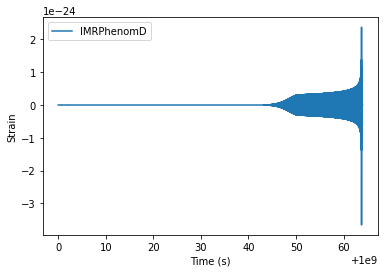

In [10]:
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform

# Time, orientation and location of the source in the sky
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0
time = 1000000000

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))

# These factors allow us to project a signal into what the detector would
# observe

## Generate a waveform
hp, hc = get_td_waveform(approximant="IMRPhenomPv2", mass1=samples['mass_1'][0], mass2=samples['mass_2'][0], spin1x=samples['spin1x'][0], 
                         spin2x = samples['spin2x'][0], spin1z=samples['spin1z'][0], spin2z=samples['spin2z'][0],
                         f_lower=30, delta_t=1.0/4096, inclination=inc,
                         distance=samples['dl'][0])

# ## Apply the factors to get the detector frame strain
# ht = fp * hp + fc * hc


# The projection process can also take into account the rotation of the
# earth using the project wave function.
hp.start_time = hc.start_time = time
ht = d.project_wave(hp, hc, ra, dec, pol)

times = np.array(ht.sample_times)
#h = np.array(ht)[-1024:]
times=times[-1024:]

pylab.plot(ht.sample_times, ht, label=approximant)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

(30.0, 500.0)

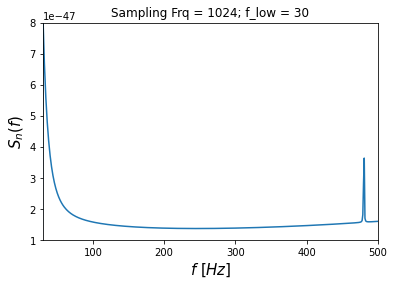

In [6]:
import lal
import lalsimulation
import matplotlib.pyplot as plt

def get_psd():
    fs = 1024              # Sampling frequency 
    f_low = 30             # Minimum frequency
    T_obs = 1              # Observation length in seconds
    N = T_obs * fs         # the total number of time samples
    dt = 1. / fs           # the sampling time (sec)
    df = 1. / T_obs        # the frequency resolution
    psd = lal.CreateREAL8FrequencySeries(None, lal.LIGOTimeGPS(0), 0.0, df, lal.HertzUnit, int((N / 2) + 1))
    lalsimulation.SimNoisePSDaLIGODesignSensitivityP1200087(psd, f_low)
    psd = psd.data.data
    return psd
# this is for H, and L. check how to get for virgo too

df = 1       #set sampling frequency 
f_min = 30    #10 Hz minimum frequency
psd = get_psd()
plt.plot(psd)
plt.ylabel(r'$S_{n}(f)$', fontsize=15)
plt.xlabel(r'$f \,\, [Hz]$', fontsize=15)
plt.title('Sampling Frq = '+str(1024)+ '; f_low = '+str(f_min))
plt.ylim([10**(-47), 8*10**(-47)])
plt.xlim([30, 500])

In [11]:
from scipy import signal
def get_snr(data, T_obs, fs, psd, fmin):

    N = int(T_obs * fs)
    df = 1.0 / T_obs
    dt = 1.0 / fs
    fidx = int(fmin / df)
    win = signal.tukey(N, alpha=(1.0 / 8.0))
    idx = np.argwhere(psd > 0.0)
    invpsd = np.zeros(psd.size)
    invpsd[idx] = 1.0 / psd[idx]
    xf = np.fft.rfft(data*win)*dt
    print(xf[500])
    SNRsq = 4.0 * np.sum((np.abs(xf[fidx:]) **2 ) * invpsd[fidx:]) * df
    return np.sqrt(SNRsq)



get_snr(h, 1, 1024, psd, 30)

(3.661235552064836e-30-6.9992565842043945e-31j)


12.667065217414459

In [7]:

ifos = ['H1', 'L1', 'V1']
h1 = read_frame('H-H1_LOSC_4_V2-1126259446-32.gwf', 'H1:LOSC-STRAIN')
h1 = highpass_fir(h1, 15, 8)
# Calculate the noise spectrum
psd = interpolate(welch(h1), 1.0 / h1.duration)

psd = data.psd["C01:IMRPhenomXPHM"]

# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                         f_lower=20, delta_f=1.0/h1.duration)
# with IMRPhenomXP can include other variables
hp.resize(len(h1) // 2 + 1)


# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=20.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pp.plot(snr.sample_times, abs(snr))
pp.ylabel('signal-to-noise')
pp.xlabel('GPS Time (s)')
pp.show()

XLAL Error - XLALFrStreamFileOpen (LALFrStream.c:128): No files in stream file cache
XLAL Error - XLALFrStreamFileOpen (LALFrStream.c:128): Invalid argument
XLAL Error - XLALFrStreamCacheOpen (LALFrStream.c:233): Internal function call failed: Invalid argument


RuntimeError: Internal function call failed: Invalid argument

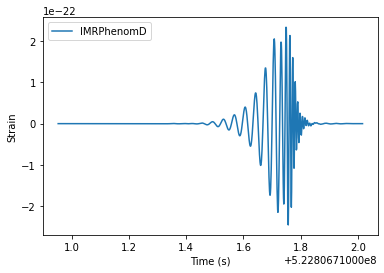

In [9]:
import pylab
from pycbc.waveform import get_td_waveform
import numpy as np
from pycbc.detector import Detector


def h_pluscross(approximant, mass1, mass2, spin1z, spin2z, distance, delta_t=1.0/2048, f_lower=30):
        hp, hc = get_td_waveform(approximant=approximant,
                                 mass1=mass1,
                                 mass2=mass2,
                                 spin1z=spin1z,
                                 spin2z=spin2z,
                                 distance=distance,
                                 delta_t=1.0/1024,
                                 f_lower=30)
        return hp, hc
    
def antenna(RA,dec,phi):
    Fp = 0.5*(1+(np.cos(dec))**2)*np.cos(2*RA)*np.cos(2*phi) + np.cos(dec)*np.sin(2*RA)*np.sin(2*phi)
    Fc = 0.5*(1+(np.cos(dec))**2)*np.cos(2*RA)*np.sin(2*phi) + np.cos(dec)*np.sin(2*RA)*np.cos(2*phi)
    
    return Fp, Fc


def h_t(hp, hc, Fp, Fc, inc):
    
    ht = hp*Fp*(1+(np.cos(inc))**2) + hc*Fc*(2*np.cos(inc))
    
    return ht

approximant =  'IMRPhenomD'

hp, hc = h_pluscross(approximant, 150, 50, 0.9, 0.5, 5500)

d = Detector("H1")
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0
time = 522806711

hp.start_time = hc.start_time = time
ht = d.project_wave(hp, hc, ra, dec, pol)

# Fp, Fc = antenna(np.pi, np.pi, 0 )
# h = h_t(hp, hc, Fp, Fc, 0.2)

times = np.array(ht.sample_times)
h = np.array(ht)[-1024:]
times=times[-1024:]

pylab.plot(ht.sample_times, ht, label=approximant)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

In [ ]:
# pycbc_condition_strain \
#     --fake-strain aLIGOAdVO4T1800545 \
#     --fake-strain-seed 1234 \
#     --fake-strain-flow 10 \
#     --sample-rate 16384 \
#     --gps-start-time 1242442818 \
#     --gps-end-time 1242442882 \
#     --channel-name V1:SIMULATED_STRAIN \
#     --injection-file injections.hdf \
#     --output-strain-file V1-SIMULATED_STRAIN-1242442818-64.gwf

SyntaxError: invalid syntax (781267114.py, line 2)

In [ ]:
help(pycbc_condition_strain)

NameError: name 'pycbc_condition_strain' is not defined

In [ ]:
# For each observatory use this template to calculate the SNR time series
snr = {}
for ifo in ifos:

    hp.resize(len(ts) / 2 + 1)
    snr[ifo] = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=25)
    snr[ifo] = snr[ifo].crop(5, 4)

In [ ]:
%matplotlib inline
import pylab
from pycbc.filter import highpass_fir
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, welch
from pycbc.catalog import Merger

for ifo in ['L1', 'H1']:
    # Read in the data into a TimeSeries
    ts = highpass_fir(Merger("GW151012").strain(ifo), 15, 16)

    # Estimate the noise spectrum
    psd = interpolate(welch(ts), 1.0 / ts.duration)
    
    # Calculate the signal-to-noise
    hp.resize(len(ts) / 2 + 1)
    snr = matched_filter(hp, ts, psd=psd, low_frequency_cutoff=30.0)

    # Choose the +-100ms around the event.
    i = int((time - snr.start_time) / snr.delta_t)
    snr = snr[int(i - snr.sample_rate * .1):int(i + snr.sample_rate * .1)]
    
    pylab.plot(snr.sample_times, abs(snr))